In [1]:
import pandas as pd
import numpy as np 
import sys
import os
sys.path.insert(0,'/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts')

import config
import h5py
from matplotlib import pyplot as plt 
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import ks_2samp

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler

arguments = {}
arguments["donorFile"] = "/hpc/compgen/projects/gw_cfdna/raw/external_data_haizi/unimputed/L77-D1-2.donor.frag.bed.gz"
arguments["recipientFile"] = "/hpc/compgen/projects/gw_cfdna/raw/external_data_haizi/unimputed/L77-D1-2.recipient.frag.bed.gz"

In [2]:
columnNames  = ["#chrom", "start", "end", "read_id", "mapq", "cigar1", "cigar2"]
fullDonorNumpy = pd.read_csv(arguments["donorFile"],
            sep = "\t", names = columnNames, skiprows=11).to_numpy()
fullRecipientNumpy = pd.read_csv(arguments["recipientFile"],
            sep = "\t", names = columnNames, skiprows=11).to_numpy()

print("Done reading bed files")

#TODO remove once testing is done
# fullDonorNumpy = fullDonorNumpy[0:15]
# fullRecipientNumpy = fullRecipientNumpy[0:15]
print(fullDonorNumpy)

donorRows, donorCols = fullDonorNumpy.shape
recipRows, recipCols = fullRecipientNumpy.shape

donorLabelsArray = np.zeros((donorRows, 1))
recipLabelsArray = np.ones((recipRows, 1))

lengthNumpyDonor = fullDonorNumpy[:,2].astype(int) - fullDonorNumpy[:,1].astype(int)
lengthNumpyDonor = lengthNumpyDonor.reshape((donorRows, 1))
lengthNumpyDonor = np.append(lengthNumpyDonor, donorLabelsArray, axis=1)

lengthNumpyRecip = fullRecipientNumpy[:,2].astype(int) - fullRecipientNumpy[:,1].astype(int)
lengthNumpyRecip = lengthNumpyRecip.reshape((recipRows, 1))
lengthNumpyRecip = np.append(lengthNumpyRecip, recipLabelsArray, axis=1)

lengthArrayToPlot = np.append(lengthNumpyDonor,lengthNumpyRecip,axis=0)
print(lengthArrayToPlot)

Done reading bed files
[['1' 1254282 1254454 ... 60 '101M' '100M']
 ['1' 1346863 1347024 ... 60 '101M' '101M']
 ['1' 1346888 1347047 ... 60 '101M' '101M']
 ...
 ['X' 152726250 152726409 ... 60 '100M' '101M']
 ['X' 153591350 153591514 ... 60 '101M' '101M']
 ['X' 154078788 154078950 ... 60 '101M' '101M']]
[[172.   0.]
 [161.   0.]
 [159.   0.]
 ...
 [190.   1.]
 [190.   1.]
 [183.   1.]]


In [ ]:
bins = bins=np.linspace(80, 280, 21)

#The number of donor fragments is much lower than the number of recipient fragments. So if we plot just the numbers 
#there is an imbalance. Keeping this plot in, just to show that donor data is much less compared to recipient data
n, donorHist, _ = plt.hist(lengthNumpyDonor[:,0],bins = bins, histtype=u'step', label = "donor fragment lengths")
plt.xticks(bins)
plt.xticks(rotation=90)

n, recipHist, _ = plt.hist(lengthNumpyRecip[:,0],bins = bins, histtype=u'step', label = "recipient fragment lengths")
plt.xticks(bins)
plt.xticks(rotation=90)

plt.legend(loc='upper right')
plt.show()

#Plot the densities to fix the imbalance
n, donorHist, _ = plt.hist(lengthNumpyDonor[:,0],bins = bins, histtype=u'step', label = "donor fragment lengths", density = True)
plt.xticks(bins)
plt.xticks(rotation=90)

n, recipHist, _ = plt.hist(lengthNumpyRecip[:,0],bins = bins, histtype=u'step', label = "recipient fragment lengths", density = True)
plt.xticks(bins)
plt.xticks(rotation=90)

plt.legend(loc='upper right')
plt.show()

plt.hist(lengthArrayToPlot[:,0],bins = bins, histtype = u'step')
plt.xticks(bins)
plt.xticks(rotation=90)
plt.show()

**methods to generate plots from logistic regression predictions**

In [24]:
#Plot confusion matrix heatmap 
def getConfusionMatrix(y_pred, y_true):
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    cf_matrix_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    cf_matrix_labels = np.asarray(cf_matrix_labels).reshape(2,2)
    return cf_matrix, cf_matrix_labels

# def makeConfusionMatrixPlot(y_pred_train, y_train, y_pred_test, y_test):
#     training_cf_matrix, training_cf_matrix_labels = getConfusionMatrix(y_pred_train, y_train)
#     test_cf_matrix, test_cf_matrix_labels = getConfusionMatrix(y_pred_test, y_test)

#     x_labels = ["Donor (Neg)", "Recip (Pos)"]
#     y_labels = ["Donor (Neg)", "Recip (Pos)"]

#     fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 8))
#     s1 = sns.heatmap(training_cf_matrix, annot=training_cf_matrix_labels, fmt = '', cmap="Blues", ax=ax1, annot_kws={"fontsize":12}, xticklabels=x_labels, yticklabels=y_labels)
#     s2 = sns.heatmap(test_cf_matrix, annot=test_cf_matrix_labels, fmt = '', cmap="Blues", ax=ax2, annot_kws={"fontsize":12}, xticklabels=x_labels, yticklabels=y_labels)
#     s1.set_xlabel("Predicted Label", fontsize=12)
#     s1.set_ylabel("True Label", fontsize=12)
#     s2.set_xlabel("Predicted Label", fontsize=12)
#     s2.set_ylabel("True Label", fontsize=12)
#     s1.tick_params(axis='x', labelsize=10)
#     s1.tick_params(axis='y', labelsize=10)
#     s2.tick_params(axis='x', labelsize=10)
#     s2.tick_params(axis='y', labelsize=10)

#     s1.get_xaxis().set_label_coords(0.5, -0.1)
#     s1.get_yaxis().set_label_coords(-0.2, 0.5)
#     s2.get_xaxis().set_label_coords(0.5, -0.1)
#     s2.get_yaxis().set_label_coords(-0.2, 0.5)

#     fig.subplots_adjust(hspace=0.75, wspace=0.75)

#     ax1.title.set_text(f'Training Confusion Matrix')
#     ax2.title.set_text(f'Test Confusion Matrix')
#     plt.show()

def makeConfusionMatrixPlot(y_pred_train, y_train, y_pred_test, y_test):
    test_cf_matrix, test_cf_matrix_labels = getConfusionMatrix(y_pred_test, y_test)

    x_labels = ["Donor (Neg)", "Recip (Pos)"]
    y_labels = ["Donor (Neg)", "Recip (Pos)"]

    s1 = sns.heatmap(test_cf_matrix, annot=test_cf_matrix_labels, fmt = '', cmap="Blues", annot_kws={"fontsize":12}, xticklabels=x_labels, yticklabels=y_labels)
    s1.set_xlabel("Predicted Label", fontsize=12)
    s1.set_ylabel("True Label", fontsize=12)
    s1.tick_params(axis='x', labelsize=10)
    s1.tick_params(axis='y', labelsize=10)

    s1.get_xaxis().set_label_coords(0.5, -0.1)
    s1.get_yaxis().set_label_coords(-0.2, 0.5)
    plt.show()

def makeRocAucPlot(y_pred_prob, y_test):
    auc_score = roc_auc_score(y_test, y_pred_prob)
    train_fpr, train_tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=1)

    #Get random predictions
    random_pred_val = [0 for i in range(len(y_test))]
    r_fpr, r_tpr, _ = roc_curve(y_test, random_pred_val, pos_label=1)

    plt.plot(train_fpr, train_tpr, linestyle='--',color='red', label='logistic regression model')
    plt.plot(r_fpr, r_tpr, linestyle='--', color='black', label = "random predictor")
    plt.title(f'AUC : {auc_score}')
    plt.xlabel('False Positive Rate/FPR')
    plt.ylabel('True Positive Rate/TPR')
    plt.legend(loc='best')
    plt.show()

**Get length distribution data**

In [18]:
def map_class_name(label):
    if label == 1.0:
        return 'donor'
    elif label == 0.0:
        return 'recipient'

def getDataForLengthDistribution():
    dirPath = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/biggerSubsetClassBalancedCoordinateFiles"
    fullArray = np.zeros(2).reshape(1, 2)
    count = 0
    for filename in os.listdir(dirPath):
        count = count + 1
        filePath = os.path.join(dirPath, filename)
        with h5py.File(filePath, 'r') as f:
            #Get length and labels array for training set
            trainCoords = f["trainingCoords"][:]
            trainLabels = f["trainingLabels"][:]
            trainCoords = trainCoords.astype(int)
            trainLengths = trainCoords[:, 2] - trainCoords[:, 1]
            trainLengths = trainLengths.reshape(len(trainLengths), 1)
            trainArray = np.append(trainLengths, trainLabels, axis = 1)

            #Get length and labels array for validation
            validationCoords = f["validationCoords"][:]
            validationLabels = f["validationLabels"][:]
            validationCoords = validationCoords.astype(int)
            validationLengths = validationCoords[:, 2] - validationCoords[:, 1]
            validationLengths = validationLengths.reshape(len(validationLengths), 1)
            validationArray = np.append(validationLengths, validationLabels, axis = 1)

            singleFileArray = np.append(trainArray, validationArray, axis = 0)
            fullArray = np.append(fullArray, singleFileArray, axis = 0)
    print(f"Count : {count}")
    print(fullArray.shape)
    length_df = pd.DataFrame(fullArray[1:, :], columns = ['length of fragment(bps)','label'])

    # # Add the "class_name" column based on the "label" column
    # Define a mapping dictionary for labels
    label_mapping = {0: "donor", 1: "recipient"}

    # Apply the mapping to the 'label' column
    length_df['cfDNA fragment class'] = length_df['label'].map(label_mapping)

    # print(length_df["label"].value_counts())
    # # print(length_df["class_name"].value_counts())
    return length_df


**Calculate the statistical significance of length distribution**

In [ ]:
length_df = getDataForLengthDistribution()
donor_lengths = length_df[length_df['label'] == 0]['length of fragment(bps)']
recipient_lengths = length_df[length_df['label'] == 1]['length of fragment(bps)']

ks_statistic, p_value = ks_2samp(donor_lengths, recipient_lengths)

# Visualize the length distributions
plt.hist(donor_lengths, alpha=0.5, label='Donor-derived')
plt.hist(recipient_lengths, alpha=0.5, label='Recipient-derived')
plt.legend()
plt.show()

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

**Make length distribution plot**

In [ ]:
# # Define a function to mark peaks in a KDE plot
# def mark_peaks(data, label, color):
#     # Calculate the KDE
#     kde = sns.kdeplot(data, color=color, label=f'{label} (KDE)', shade=True)
    
#     kde_lines = kde.get_lines()
#     if len(kde_lines) > 0:
#         peaks, _ = find_peaks(kde_lines[0].get_ydata(), height=0)  # You can adjust the 'height' parameter
#         if len(peaks) > 0:
#             peak_x = kde_lines[0].get_xdata()[peaks]
#             peak_y = kde_lines[0].get_ydata()[peaks]
#             plt.scatter(peak_x, peak_y, marker='o', color='red', label=f'Peaks ({label})')

length_df = getDataForLengthDistribution()  
ax = sns.kdeplot(data = length_df, x = "length of fragment(bps)", hue = "cfDNA fragment class")
# labels = ["Donor-derived cfDNA", "Recipient-derived cfDNA"]
# ax.legend(labels = labels, loc = "upper right") 
plt.show()


Count : 142
(574224, 2)
   length of fragment(bps)  label cfDNA fragment class
0                    221.0    0.0                donor
1                    204.0    0.0                donor
2                    163.0    0.0                donor
3                    164.0    0.0                donor
4                    197.0    0.0                donor
5                    165.0    0.0                donor
6                    178.0    0.0                donor
7                    170.0    0.0                donor
8                    182.0    0.0                donor
9                    181.0    0.0                donor
(401956, 1) (172267, 1) 401956 172267
Training: True positives: 200892,True negatives: 201064
Test: True positives: 86178, True Negatives: 86089
Training: Predicted Positives: 176343, Predicted Negatives: 225613
Test: Predicted Positives: 75892, Predicted Negatives: 96375
(401956, 1) (172267, 1) 401956 172267
Training: True positives: 200892,True negatives: 201064
Test

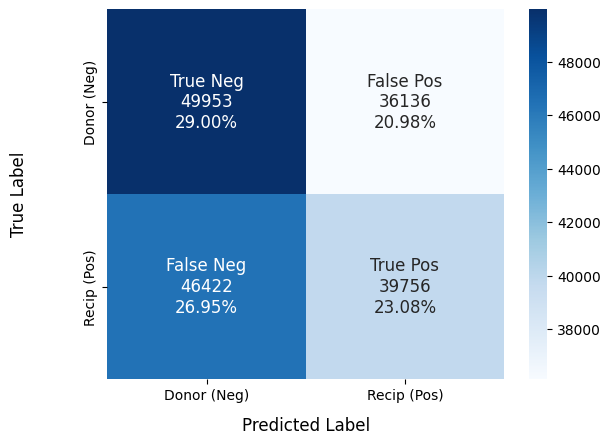

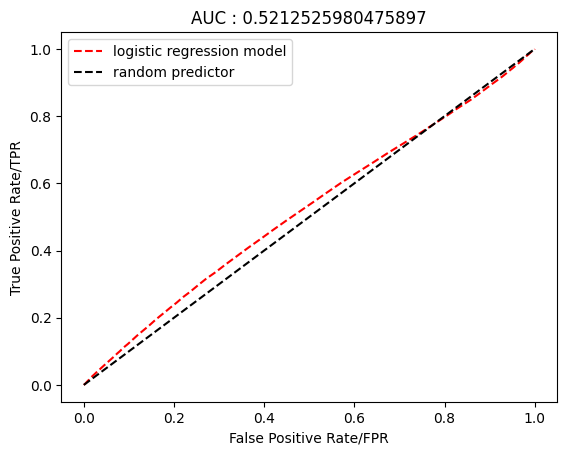

In [25]:
def getLogisticRegressionPredictions(features_df, labels):
    #We have to remove all columns with string values before doing the scaling operations. 
    features_df = features_df.drop(columns = ["cfDNA fragment class"])
    x_train, x_test, y_train, y_test = train_test_split(features_df, labels, test_size = 0.3, random_state = 0, shuffle=True)
    print(x_train.shape, x_test.shape, len(y_train), len(y_test))

    #The data from all different Enformer tracks could have different scales. Scale, so the model can converge faster
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.fit_transform(x_test)

    #Train logistic regression model and get predictions
    logreg = LogisticRegression(random_state=16, solver='lbfgs', max_iter=1000)
    logreg.fit(x_train_scaled, y_train)
    y_pred_train = logreg.predict(x_train_scaled)
    y_pred_test = logreg.predict(x_test_scaled)
    y_pred_prob = logreg.predict_proba(x_test_scaled)[::,1]

    print(f"Training: True positives: {y_train.count(1)},True negatives: {y_train.count(0)}")
    print(f"Test: True positives: {y_test.count(1)}, True Negatives: {y_test.count(0)}")
    print(f"Training: Predicted Positives: {(y_pred_train == 1).sum()}, Predicted Negatives: {(y_pred_train == 0).sum()}")
    print(f"Test: Predicted Positives: {(y_pred_test == 1).sum()}, Predicted Negatives: {(y_pred_test == 0).sum()}")

    return y_train, y_pred_train, y_test, y_pred_test, y_pred_prob
    
length_df = getDataForLengthDistribution()
print(length_df.head(10))
features_df = length_df.drop(['label'], axis = 1)
labels = length_df['label'].tolist()
y_train, y_pred_train, y_test, y_pred_test, y_pred_prob = getLogisticRegressionPredictions(features_df, labels)
makeConfusionMatrixPlot(y_pred_train, y_train, y_pred_test, y_test)

makeRocAucPlot(y_pred_prob, y_test)